# **Imports**


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,precision_score, recall_score, f1_score, precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV

# **Data Loading and Exploration**



In [2]:
categories = None
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=('headers', 'footers', 'quotes'))

df_train = pd.DataFrame({'text': newsgroups_train.data, 'target': newsgroups_train.target})
df_test = pd.DataFrame({'text': newsgroups_test.data, 'target': newsgroups_test.target})

print("Number of Training Samples:", len(df_train))
print("Number of Test Samples:", len(df_test))
print("Number of Categories:", len(newsgroups_train.target_names))

df_train.head()


Number of Training Samples: 11314
Number of Test Samples: 7532
Number of Categories: 20


,text,target
0,I was wondering if anyone out there could enli...,7
1,A fair number of brave souls who upgraded thei...,4
2,"well folks, my mac plus finally gave up the gh...",4
3,\nDo you have Weitek's address/phone number? ...,1
4,"From article <C5owCB.n3p@world.std.com>, by to...",14


In [3]:
df_train['target'].value_counts()

,count
target,
10,600
15,599
8,598
9,597
11,595
13,594
7,594
14,593
5,593


In [4]:
for idx, category in enumerate(newsgroups_train.target_names):
    print(f"{idx}: {category}")


0: alt.atheism
1: comp.graphics
2: comp.os.ms-windows.misc
3: comp.sys.ibm.pc.hardware
4: comp.sys.mac.hardware
5: comp.windows.x
6: misc.forsale
7: rec.autos
8: rec.motorcycles
9: rec.sport.baseball
10: rec.sport.hockey
11: sci.crypt
12: sci.electronics
13: sci.med
14: sci.space
15: soc.religion.christian
16: talk.politics.guns
17: talk.politics.mideast
18: talk.politics.misc
19: talk.religion.misc


# **Clean Text**

In [5]:
import re
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\W+', ' ', text)
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

df_train['cleaned_text'] = df_train['text'].apply(clean_text)
df_test['cleaned_text'] = df_test['text'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Preprocessing and TF-IDF Vectorization**



In [6]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)

X_train_tfidf = tfidf_vectorizer.fit_transform(df_train['cleaned_text'])
X_test_tfidf = tfidf_vectorizer.transform(df_test['cleaned_text'])

y_train = df_train['target']
y_test = df_test['target']

print("Shape of TF-IDF matrix:", X_train_tfidf.shape)


Shape of TF-IDF matrix: (11314, 101295)


# **Model Training and Evaluation Functions**


In [7]:
# Define training functions
def train_naive_bayes(X_train, y_train):
    nb_model = MultinomialNB()
    nb_model.fit(X_train, y_train)
    return nb_model

def train_random_forest(X_train, y_train):
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    return rf_model

def train_xgboost(X_train, y_train):
    xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    xgb_model.fit(X_train, y_train)
    return xgb_model


def train_logistic_regression(X_train, y_train):
    lr_model = LogisticRegression(max_iter=1000, random_state=42)
    lr_model.fit(X_train, y_train)
    return lr_model


def train_svm(X_train, y_train):
    svm_model = SVC(kernel='linear', random_state=42)
    svm_model.fit(X_train, y_train)
    return svm_model

def train_knn(X_train, y_train):
    knn_model = KNeighborsClassifier(n_neighbors=5)
    knn_model.fit(X_train, y_train)
    return knn_model

def train_lgb(X_train, y_train):
    lgb_model = lgb.LGBMClassifier()
    lgb_model.fit(X_train, y_train)
    return lgb_model

def train_pac(X_train, y_train):
    pac_model = PassiveAggressiveClassifier(max_iter=1000, random_state=42)
    pac_model.fit(X_train, y_train)
    return pac_model

# Evaluate and visualize
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"🔹 {model_name} Accuracy: {acc:.4f}\n")
    print(f"🔹 Classification Report for {model_name}:")
    # Use all target names instead of just the first 5
    print(classification_report(y_test, y_pred, target_names=newsgroups_train.target_names))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, cmap='Blues', annot=False)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()
    return acc


# **Train Models**

🔹 Logistic Regression Accuracy: 0.6914

🔹 Classification Report for Logistic Regression:
                          precision    recall  f1-score   support

             alt.atheism       0.50      0.46      0.48       319
           comp.graphics       0.63      0.71      0.67       389
 comp.os.ms-windows.misc       0.65      0.62      0.64       394
comp.sys.ibm.pc.hardware       0.68      0.64      0.66       392
   comp.sys.mac.hardware       0.75      0.69      0.72       385
          comp.windows.x       0.84      0.73      0.78       395
            misc.forsale       0.75      0.79      0.77       390
               rec.autos       0.76      0.71      0.73       396
         rec.motorcycles       0.48      0.81      0.60       398
      rec.sport.baseball       0.82      0.82      0.82       397
        rec.sport.hockey       0.91      0.87      0.89       399
               sci.crypt       0.90      0.66      0.76       396
         sci.electronics       0.56      0.61      0

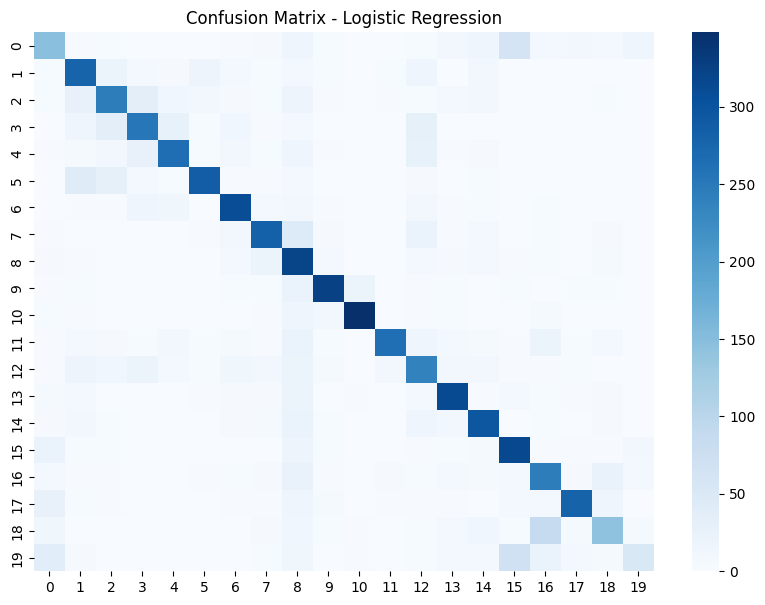

🔹 Naive Bayes Accuracy: 0.6799

🔹 Classification Report for Naive Bayes:
                          precision    recall  f1-score   support

             alt.atheism       0.78      0.18      0.30       319
           comp.graphics       0.67      0.69      0.68       389
 comp.os.ms-windows.misc       0.66      0.59      0.62       394
comp.sys.ibm.pc.hardware       0.60      0.74      0.66       392
   comp.sys.mac.hardware       0.77      0.67      0.72       385
          comp.windows.x       0.81      0.77      0.79       395
            misc.forsale       0.77      0.77      0.77       390
               rec.autos       0.83      0.73      0.78       396
         rec.motorcycles       0.87      0.74      0.80       398
      rec.sport.baseball       0.93      0.80      0.86       397
        rec.sport.hockey       0.57      0.93      0.71       399
               sci.crypt       0.59      0.79      0.68       396
         sci.electronics       0.71      0.52      0.60       393
  

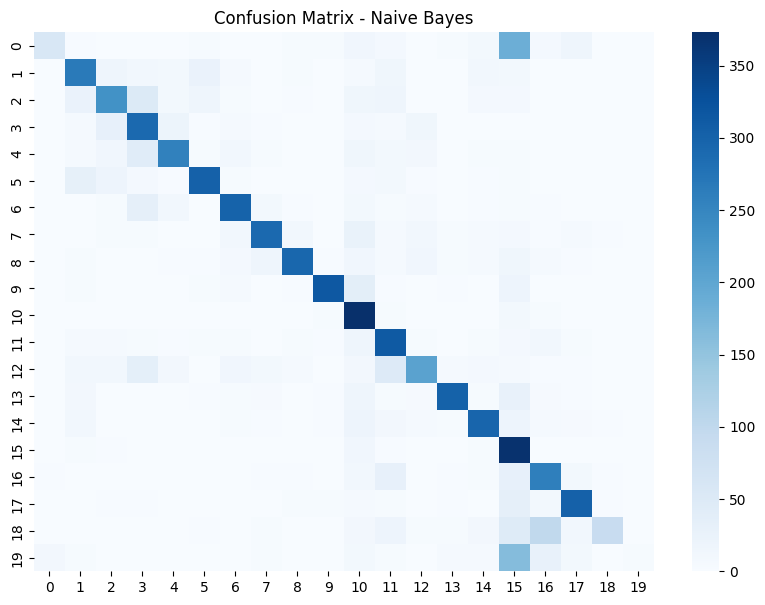

🔹 Support Vector Machine Accuracy: 0.6747

🔹 Classification Report for Support Vector Machine:
                          precision    recall  f1-score   support

             alt.atheism       0.48      0.47      0.47       319
           comp.graphics       0.60      0.71      0.65       389
 comp.os.ms-windows.misc       0.65      0.61      0.63       394
comp.sys.ibm.pc.hardware       0.65      0.66      0.66       392
   comp.sys.mac.hardware       0.73      0.65      0.69       385
          comp.windows.x       0.86      0.66      0.75       395
            misc.forsale       0.77      0.78      0.77       390
               rec.autos       0.65      0.73      0.68       396
         rec.motorcycles       0.45      0.79      0.58       398
      rec.sport.baseball       0.81      0.78      0.79       397
        rec.sport.hockey       0.92      0.82      0.87       399
               sci.crypt       0.89      0.68      0.77       396
         sci.electronics       0.56      0.61 

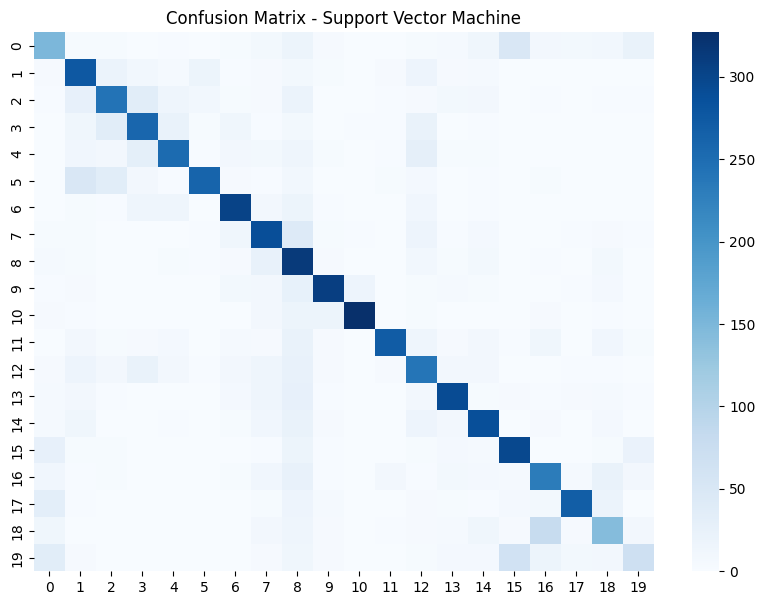

🔹 Random Forest Accuracy: 0.6298

🔹 Classification Report for Random Forest:
                          precision    recall  f1-score   support

             alt.atheism       0.44      0.37      0.40       319
           comp.graphics       0.60      0.60      0.60       389
 comp.os.ms-windows.misc       0.57      0.66      0.61       394
comp.sys.ibm.pc.hardware       0.61      0.58      0.59       392
   comp.sys.mac.hardware       0.63      0.67      0.65       385
          comp.windows.x       0.66      0.67      0.66       395
            misc.forsale       0.73      0.75      0.74       390
               rec.autos       0.41      0.71      0.52       396
         rec.motorcycles       0.70      0.68      0.69       398
      rec.sport.baseball       0.70      0.79      0.74       397
        rec.sport.hockey       0.84      0.84      0.84       399
               sci.crypt       0.81      0.66      0.73       396
         sci.electronics       0.51      0.40      0.45       39

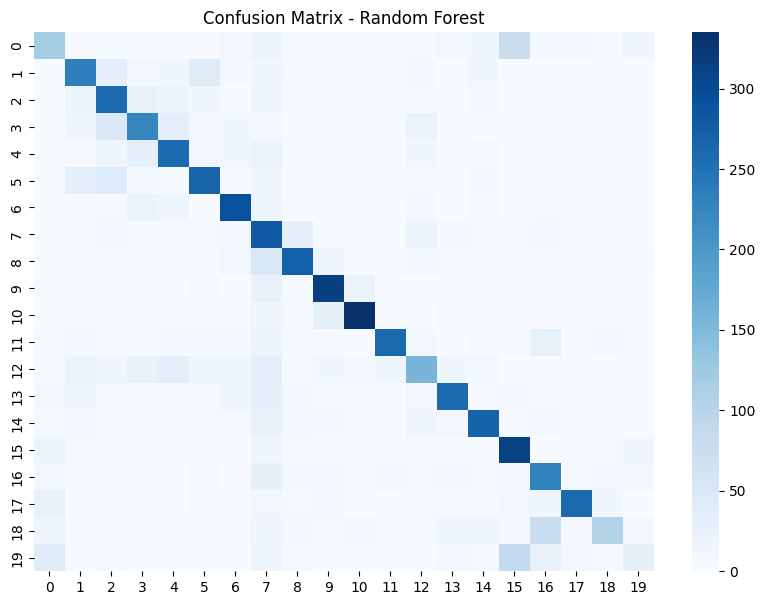

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:05:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


🔹 XGBoost Accuracy: 0.6054

🔹 Classification Report for XGBoost:
                          precision    recall  f1-score   support

             alt.atheism       0.43      0.35      0.38       319
           comp.graphics       0.57      0.63      0.60       389
 comp.os.ms-windows.misc       0.57      0.58      0.57       394
comp.sys.ibm.pc.hardware       0.59      0.57      0.58       392
   comp.sys.mac.hardware       0.64      0.66      0.65       385
          comp.windows.x       0.74      0.64      0.69       395
            misc.forsale       0.72      0.71      0.71       390
               rec.autos       0.62      0.60      0.61       396
         rec.motorcycles       0.41      0.73      0.52       398
      rec.sport.baseball       0.73      0.70      0.71       397
        rec.sport.hockey       0.81      0.78      0.80       399
               sci.crypt       0.77      0.64      0.70       396
         sci.electronics       0.45      0.47      0.46       393
          

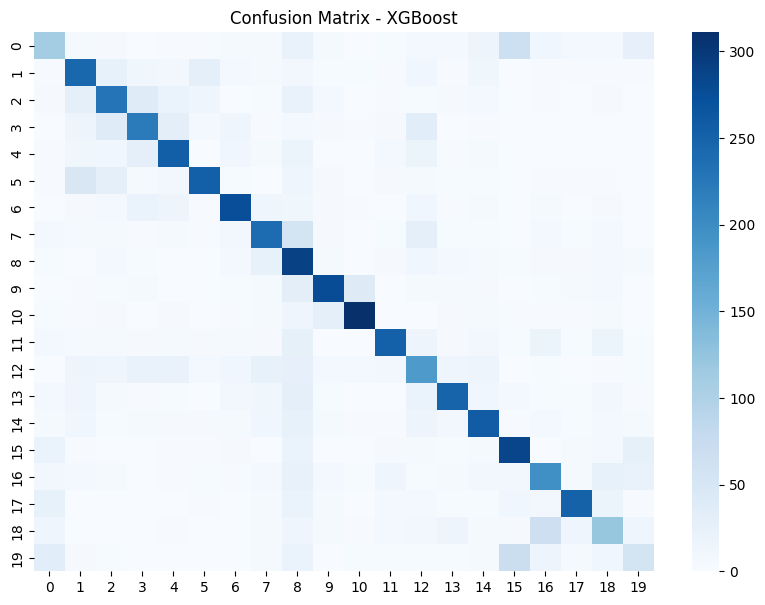

🔹 knn Accuracy: 0.0791

🔹 Classification Report for knn:
                          precision    recall  f1-score   support

             alt.atheism       0.05      0.15      0.08       319
           comp.graphics       0.06      0.16      0.09       389
 comp.os.ms-windows.misc       0.07      0.21      0.10       394
comp.sys.ibm.pc.hardware       0.12      0.13      0.13       392
   comp.sys.mac.hardware       0.07      0.12      0.09       385
          comp.windows.x       0.29      0.04      0.07       395
            misc.forsale       0.14      0.07      0.10       390
               rec.autos       0.05      0.10      0.06       396
         rec.motorcycles       0.11      0.07      0.08       398
      rec.sport.baseball       0.07      0.07      0.07       397
        rec.sport.hockey       0.12      0.07      0.09       399
               sci.crypt       0.12      0.03      0.05       396
         sci.electronics       0.09      0.04      0.06       393
                 s

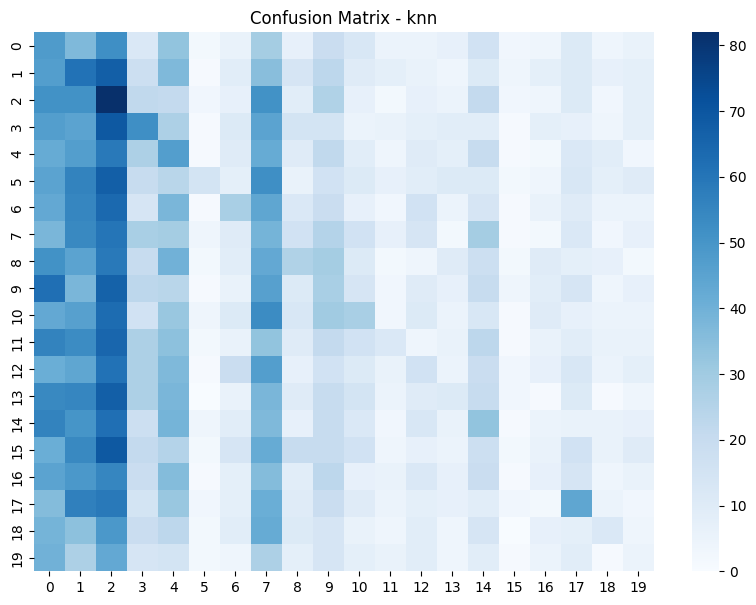

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.787016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 174338
[LightGBM] [Info] Number of data points in the train set: 11314, number of used features: 5995
[LightGBM] [Info] Start training from score -3.160010
[LightGBM] [Info] Start training from score -2.963895
[LightGBM] [Info] Start training from score -2.951980
[LightGBM] [Info] Start training from score -2.953674
[LightGBM] [Info] Start training from score -2.974222
[LightGBM] [Info] Start training from score -2.948602
[LightGBM] [Info] Start training from score -2.962184
[LightGBM] [Info] Start training from score -2.946917
[LightGBM] [Info] Start training from score -2.940205
[LightGBM] [Info] Start training from score -2.941879
[LightGBM] [Info] Start training from score -2.936867
[LightGBM] [Info] Start training from score -2.94

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


🔹 lightgbm Accuracy: 0.6115

🔹 Classification Report for lightgbm:
                          precision    recall  f1-score   support

             alt.atheism       0.39      0.40      0.39       319
           comp.graphics       0.54      0.62      0.58       389
 comp.os.ms-windows.misc       0.57      0.60      0.58       394
comp.sys.ibm.pc.hardware       0.58      0.57      0.57       392
   comp.sys.mac.hardware       0.66      0.65      0.66       385
          comp.windows.x       0.73      0.64      0.68       395
            misc.forsale       0.75      0.71      0.73       390
               rec.autos       0.41      0.70      0.52       396
         rec.motorcycles       0.66      0.67      0.67       398
      rec.sport.baseball       0.76      0.70      0.73       397
        rec.sport.hockey       0.83      0.80      0.82       399
               sci.crypt       0.79      0.63      0.70       396
         sci.electronics       0.50      0.51      0.50       393
        

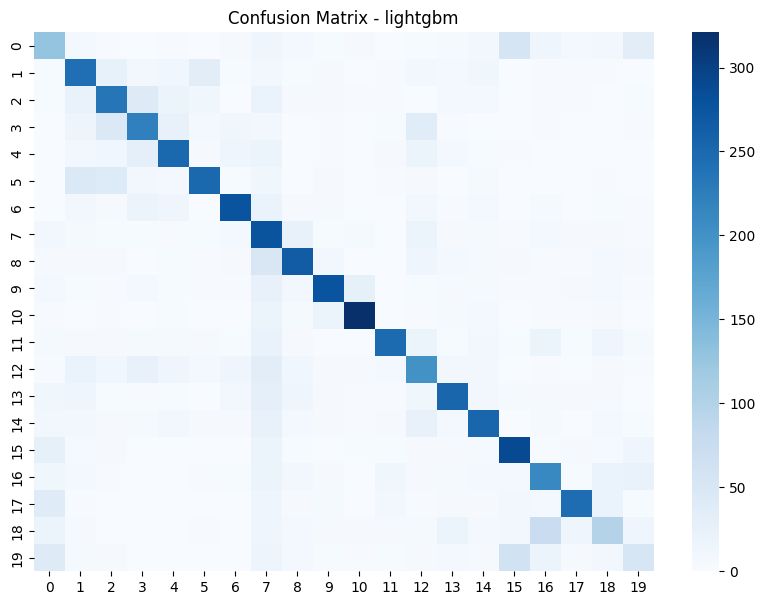

🔹 pac Accuracy: 0.6743

🔹 Classification Report for pac:
                          precision    recall  f1-score   support

             alt.atheism       0.52      0.48      0.50       319
           comp.graphics       0.64      0.71      0.67       389
 comp.os.ms-windows.misc       0.62      0.60      0.61       394
comp.sys.ibm.pc.hardware       0.59      0.63      0.61       392
   comp.sys.mac.hardware       0.71      0.67      0.69       385
          comp.windows.x       0.79      0.69      0.74       395
            misc.forsale       0.71      0.74      0.73       390
               rec.autos       0.76      0.69      0.72       396
         rec.motorcycles       0.48      0.77      0.59       398
      rec.sport.baseball       0.87      0.79      0.83       397
        rec.sport.hockey       0.86      0.86      0.86       399
               sci.crypt       0.83      0.70      0.76       396
         sci.electronics       0.66      0.57      0.61       393
                 s

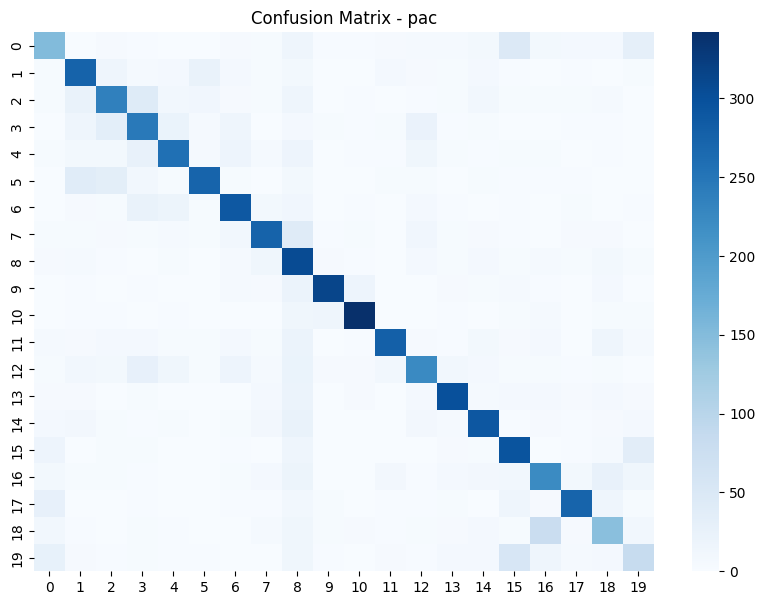

In [8]:
# Logistic regression
lr_model = train_logistic_regression(X_train_tfidf, y_train)
acc_lr = evaluate_model(lr_model, X_test_tfidf, y_test, "Logistic Regression")

# Naive Bayes
nb_model = train_naive_bayes(X_train_tfidf, y_train)
acc_nb = evaluate_model(nb_model, X_test_tfidf, y_test, "Naive Bayes")

# Support vector machine
svm_model = train_svm(X_train_tfidf, y_train)
acc_svm = evaluate_model(svm_model, X_test_tfidf, y_test, "Support Vector Machine")

# Random Forest
rf_model = train_random_forest(X_train_tfidf, y_train)
acc_rf = evaluate_model(rf_model, X_test_tfidf, y_test, "Random Forest")

# XGBoost
xgb_model = train_xgboost(X_train_tfidf, y_train)
acc_xgb = evaluate_model(xgb_model, X_test_tfidf, y_test, "XGBoost")

# KNN
knn_model = train_knn(X_train_tfidf, y_train)
acc_knn = evaluate_model(knn_model, X_test_tfidf, y_test, "KNN")

# LightGBM
lgb_model = train_lgb(X_train_tfidf, y_train)
acc_lgb = evaluate_model(lgb_model, X_test_tfidf, y_test, "LightGBM" )

# PAC
pac_model = train_pac(X_train_tfidf, y_train)
acc_pac = evaluate_model(pac_model, X_test_tfidf, y_test, "PAC" )

# **Performance**

<ipython-input-9-466d7576c9d0>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names_extended, y=accuracies_extended, palette='viridis')


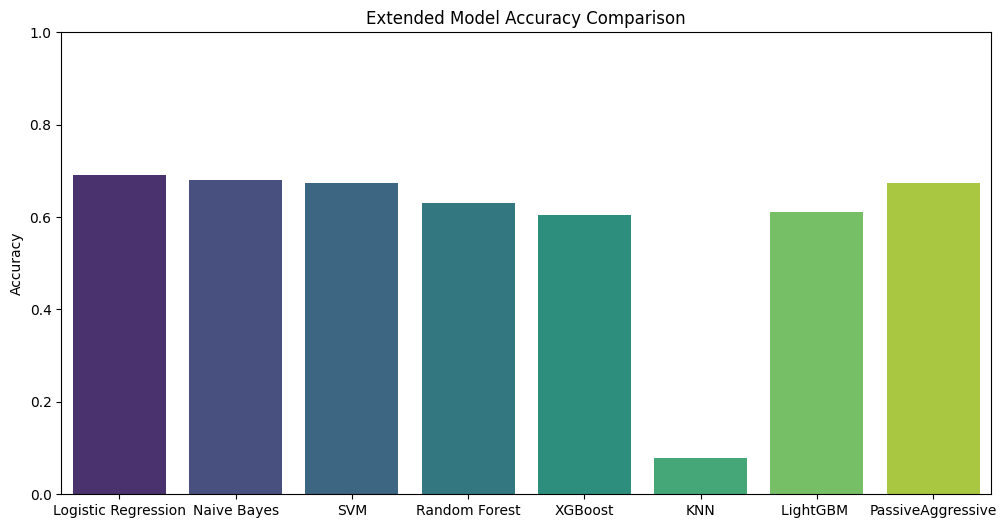

In [9]:
model_names_extended = ['Logistic Regression', 'Naive Bayes', 'SVM', 'Random Forest', 'XGBoost', 'KNN', 'LightGBM ', 'PassiveAggressive']
accuracies_extended = [acc_lr, acc_nb, acc_svm, acc_rf, acc_xgb, acc_knn, acc_lgb, acc_pac]

plt.figure(figsize=(12,6))
sns.barplot(x=model_names_extended, y=accuracies_extended, palette='viridis')
plt.title("Extended Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()


<ipython-input-10-782702c7a20b>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=model_names_extended, y=accuracies_extended, palette='viridis')


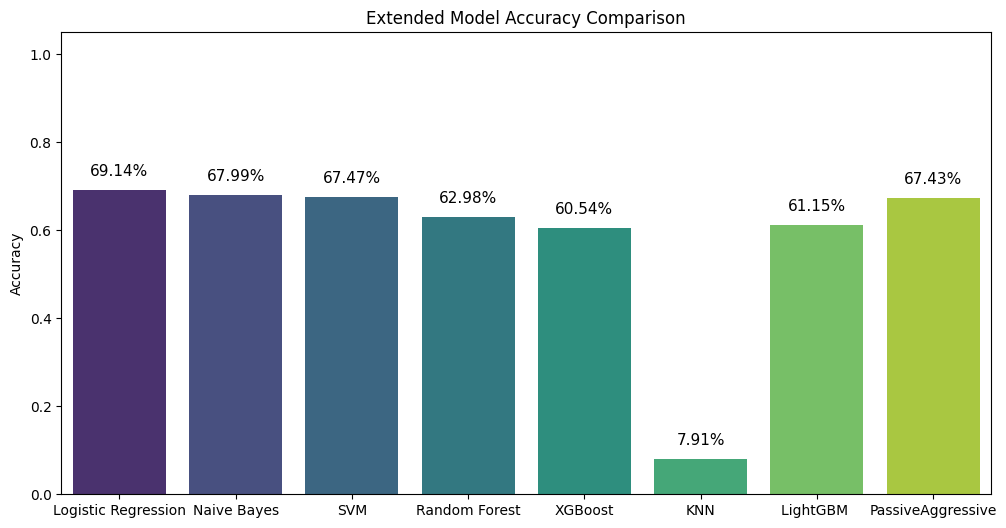

In [10]:
plt.figure(figsize=(12,6))
ax = sns.barplot(x=model_names_extended, y=accuracies_extended, palette='viridis')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2%}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                fontsize=11, color='black', xytext=(0, 8),
                textcoords='offset points')

plt.title("Extended Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1.05)
plt.show()


# **metrics**

In [11]:
models_extended = [lr_model, nb_model, svm_model, rf_model, xgb_model, knn_model, lgb_model, pac_model]

metrics_list = []

for model in models_extended:
    y_pred = model.predict(X_test_tfidf)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    metrics_list.append((precision, recall, f1))

metrics_df = pd.DataFrame(metrics_list, columns=['Precision', 'Recall', 'F1-score'])
metrics_df.insert(0, 'Model', model_names_extended)
metrics_df.insert(1, 'Accuracy', accuracies_extended)

print(metrics_df.round(4))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                 Model  Accuracy  Precision  Recall  F1-score
0  Logistic Regression    0.6914     0.7023  0.6914    0.6895
1          Naive Bayes    0.6799     0.7372  0.6799    0.6665
2                  SVM    0.6747     0.6897  0.6747    0.6762
3        Random Forest    0.6298     0.6334  0.6298    0.6240
4              XGBoost    0.6054     0.6141  0.6054    0.6055
5                  KNN    0.0791     0.1007  0.0791    0.0735
6            LightGBM     0.6115     0.6214  0.6115    0.6122
7    PassiveAggressive    0.6743     0.6833  0.6743    0.6755


# **Tuning the hyperparameters of the best models**

In [12]:
param_grid_lr = {'C': [0.01, 0.1, 1, 10], 'max_iter': [500, 1000]}
grid_lr = GridSearchCV(LogisticRegression(random_state=42), param_grid_lr, cv=3, scoring='accuracy')
grid_lr.fit(X_train_tfidf, y_train)
best_lr = grid_lr.best_estimator_

In [13]:
param_grid_nb = {'alpha': [0.01, 0.1, 1, 5, 10]}
grid_nb = GridSearchCV(MultinomialNB(), param_grid_nb, cv=3, scoring='accuracy')
grid_nb.fit(X_train_tfidf, y_train)
best_nb = grid_nb.best_estimator_

In [14]:
param_grid_pac = {'C': [0.01, 0.1, 1, 10], 'max_iter': [500, 1000]}
grid_pac = GridSearchCV(PassiveAggressiveClassifier(random_state=42), param_grid_pac, cv=3, scoring='accuracy')
grid_pac.fit(X_train_tfidf, y_train)
best_pac = grid_pac.best_estimator_

In [15]:
# Logistic Regression
y_pred_lr = best_lr.predict(X_test_tfidf)
acc_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr, average='weighted')
recall_lr = recall_score(y_test, y_pred_lr, average='weighted')
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')

# Naive Bayes
y_pred_nb = best_nb.predict(X_test_tfidf)
acc_nb = accuracy_score(y_test, y_pred_nb)
precision_nb = precision_score(y_test, y_pred_nb, average='weighted')
recall_nb = recall_score(y_test, y_pred_nb, average='weighted')
f1_nb = f1_score(y_test, y_pred_nb, average='weighted')

#PassiveAggressiveClassifier
y_pred_pac = best_pac.predict(X_test_tfidf)
acc_pac = accuracy_score(y_test, y_pred_pac)
precision_pac = precision_score(y_test, y_pred_pac, average='weighted')
recall_pac = recall_score(y_test, y_pred_pac, average='weighted')
f1_pac = f1_score(y_test, y_pred_pac, average='weighted')

<ipython-input-16-7d55ffbb48f6>:30: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


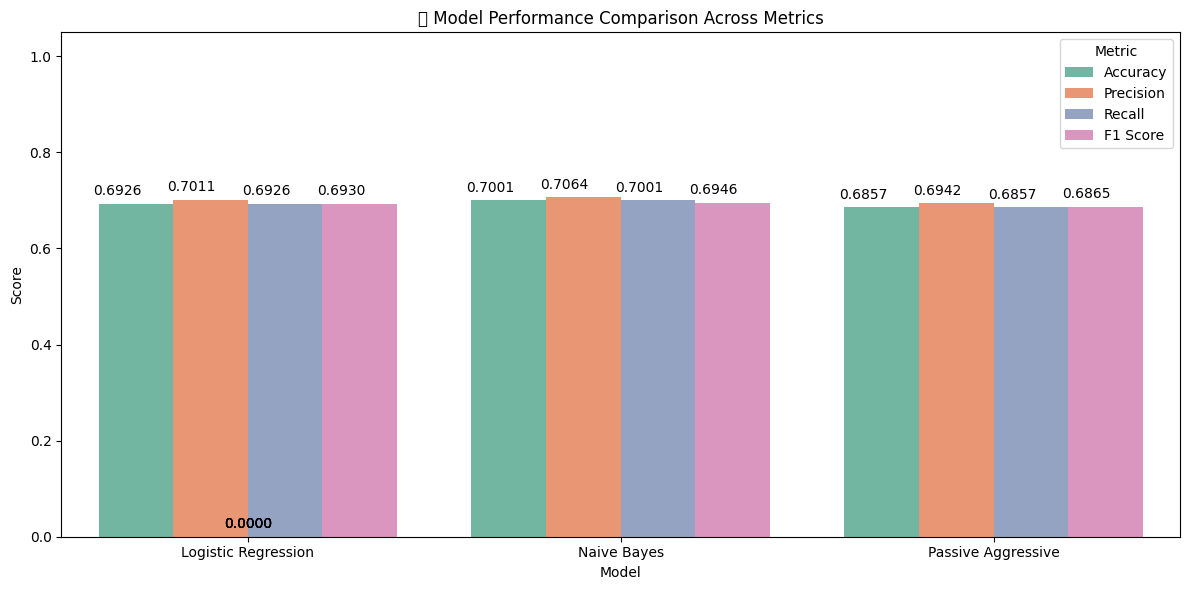

In [ ]:
model_names = ['Logistic Regression', 'Naive Bayes', 'Passive Aggressive']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

scores = [
    [acc_lr, precision_lr, recall_lr, f1_lr],
    [acc_nb, precision_nb, recall_nb, f1_nb],
    [acc_pac, precision_pac, recall_pac, f1_pac]
]

df_scores = pd.DataFrame(scores, columns=metrics, index=model_names).reset_index()
df_scores = df_scores.melt(id_vars='index', var_name='Metric', value_name='Score')
df_scores.rename(columns={'index': 'Model'}, inplace=True)

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df_scores, x='Model', y='Score', hue='Metric', palette='Set2')
plt.ylim(0, 1.05)
plt.title("Model Performance Comparison Across Metrics")
plt.ylabel("Score")
plt.xlabel("Model")
plt.legend(title="Metric")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.4f}',
                (p.get_x() + p.get_width() / 4., height),
                ha='center', va='bottom',
                fontsize=10, color='black', xytext=(0, 4),
                textcoords='offset points')

plt.tight_layout()
plt.show()
